In [46]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from torch.backends import mps
from torch.nn import (
    AvgPool2d,
    Conv2d,
    CrossEntropyLoss,
    Flatten,
    Linear,
    ReLU,
    Sequential,
)
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor

In [47]:
num_batch = 64

In [48]:
T = Compose([ToTensor()])
train_data = CIFAR10("cifar10_data", train=True, download=True, transform=T)
val_data = CIFAR10("cifar10_data", train=False, download=True, transform=T)

train_dl = DataLoader(train_data, batch_size=num_batch, shuffle=True)
val_dl = DataLoader(val_data, batch_size=num_batch, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


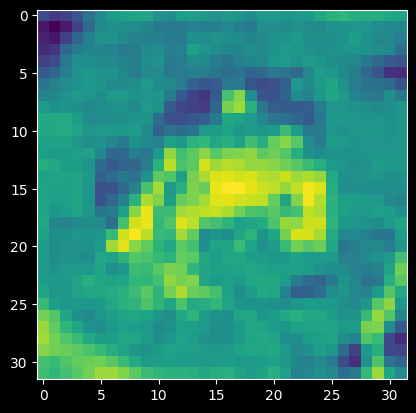

In [49]:
plt.imshow(train_data[0][0][0])

In [50]:
model = Sequential(
    Conv2d(1, 6, 5, padding=2),
    ReLU(),
    AvgPool2d(2, stride=2),
    Conv2d(6, 16, 5, padding=0),
    ReLU(),
    AvgPool2d(2, stride=2),
    Flatten(),
    Linear(400, 120),
    ReLU(),
    Linear(120, 84),
    ReLU(),
    Linear(84, 10),
)

In [51]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        # images = images.tensor()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct * 100.0 / total

In [52]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = model.to(device)
    cec = CrossEntropyLoss()
    optimizer = Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print("Epoch:", epoch + 1, "Accuracy :", accuracy, "%")
    plt.plot(accuracies)
    return best_model

In [53]:
# if mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

In [54]:
# device = torch.device("cpu")

In [55]:
lenet = train()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x576 and 400x120)

In [ ]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        # images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [ ]:
y_pred, y_true = predict_dl(lenet, val_dl)

In [ ]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0, 10)))

,0,1,2,3,4,5,6,7,8,9
0,974,0,0,0,0,0,2,0,3,1
1,0,1125,1,2,0,1,1,0,5,0
2,4,2,1016,6,1,1,0,1,1,0
3,0,0,4,989,0,3,0,0,3,11
4,1,0,1,0,968,0,5,0,0,7
5,1,0,0,13,0,865,2,0,1,10
6,5,4,0,1,1,12,935,0,0,0
7,1,2,13,5,2,0,0,990,1,14
8,5,0,5,2,4,6,1,3,939,9
9,4,3,1,4,11,0,0,2,0,984
